<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests,json
import datetime


In [0]:
covidtrackingurl = "https://covidtracking.com/api/v1/states/daily.json"
response = requests.get(covidtrackingurl)
dfCovidtracking = pd.DataFrame(response.json())
dfCovidtracking.fillna(0, inplace=True)
dfCovidtracking.negative = dfCovidtracking.negative.astype('int64')
dfCovidtracking.positive = dfCovidtracking.positive.astype('int64')
dfCovidtracking.pending = dfCovidtracking.pending.astype('int64')
dfCovidtracking.total = dfCovidtracking.total.astype('int64')
dfCovidtracking.death = dfCovidtracking.death.astype('int64')

dfCovidtracking.date = dfCovidtracking.date.transform(lambda x: pd.to_datetime(datetime.date(x//10000, x%10000//100, x%100
                                          )))
dfCovidtracking.set_index(['date'], inplace=True)


In [0]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/covid19/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"+\
"csse_covid_19_data/csse_covid_19_daily_reports/06-08-2020.csv"


dfJHUData = pd.read_csv(jhurl, header=0, usecols=[0,1,2,3,4,5,6,7,8,9,10,11],
                        names=['FIPS', 'city','state', 'country', 'last_update',
                               'lat', 'lon','confirmed', 'dead', 'recovered','active', 'key'])

In [0]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [6]:
print("US Summary")
dfCovidtracking.groupby(by='date').sum()[-3:][['positive', 'death', 'positiveIncrease', 'deathIncrease']]

US Summary


,positive,death,positiveIncrease,deathIncrease
date,,,,
2020-06-06,1916229,103947,23062,746
2020-06-07,1936161,104400,19932,453
2020-06-08,1952401,105040,16240,640


In [7]:
dfCovidtracking.loc[dfCovidtracking.state=='CA'].groupby(by='date').sum()[['positive', 'death', 'positiveIncrease', 'deathIncrease']].tail()

,positive,death,positiveIncrease,deathIncrease
date,,,,
2020-06-04,119807,4422,2120,61
2020-06-05,122901,4485,3094,63
2020-06-06,126016,4559,3115,74
2020-06-07,128812,4626,2796,67
2020-06-08,131319,4653,2507,27


In [8]:
dfctd_state_curr = dfCovidtracking.loc[dfCovidtracking.index.max()] \
  .rename(columns={'positive':'total_positive'}) \
  .set_index('state') 

print(f"Total positive cases = {dfctd_state_curr.total_positive.sum()}")
print(f"Total deaths = {dfctd_state_curr.death.sum()}")
  
dfctd_state_curr.sort_values(by='total_positive', ascending=False).head(5)

Total positive cases = 1952401
Total deaths = 105040


,total_positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,fips,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NY,378799,2177097,0,2371.0,89995.0,678.0,0.0,507.0,0.0,67687.0,A,6/8/2020 00:00,2020-06-08T00:00:00Z,06/07 20:00,24299,89995.0,2020-06-08T00:00:00Z,36,702,57352,2555896,2555896,58054,2555896,40,0,a7bffc3e14061017a57b43e110d6e010dfad6481,0,0,0,0,0,
NJ,164497,810592,0,1740.0,18050.0,498.0,0.0,361.0,0.0,27941.0,A+,6/8/2020 13:00,2020-06-08T13:00:00Z,06/08 09:00,12214,18050.0,2020-06-08T13:00:00Z,34,333,14331,975089,975089,14664,975089,38,0,0843d4ca84317156f6dc23d58f7b7089c65f8272,0,0,0,0,0,
CA,131319,2299871,0,4506.0,0.0,1301.0,0.0,0.0,0.0,0.0,B,6/8/2020 00:00,2020-06-08T00:00:00Z,06/07 20:00,4653,0.0,2020-06-08T00:00:00Z,06,2507,66465,2431190,2431190,68972,2431190,27,0,a0bcd255eefa3d6f9e6bfc5a2efbb68fb360ae46,0,0,0,0,0,
IL,129139,930458,0,2496.0,0.0,713.0,0.0,443.0,0.0,0.0,A,6/8/2020 00:59,2020-06-08T00:59:00Z,06/07 20:59,6102,0.0,2020-06-08T00:59:00Z,17,1382,15441,1059597,1059597,16823,1059597,198,0,6bcfd773c00b275f22beee25966ce23887d68b11,0,0,0,0,0,
MA,103626,553643,0,1415.0,10425.0,322.0,0.0,209.0,0.0,0.0,A+,6/8/2020 10:00,2020-06-08T10:00:00Z,06/08 06:00,7353,10425.0,2020-06-08T10:00:00Z,25,190,4589,657269,657269,4779,657269,37,32,d852bc73ec46b9bde348cd32404fabfba36e1133,0,0,0,0,0,


In [0]:
curr_state = 'CA'
gbUSA = dfCovidtracking.groupby(['date'])
gbState = dfCovidtracking[dfCovidtracking.state==curr_state].groupby(['date'])

cols = ['positive', 'totalTestResultsIncrease', 'death', 'positiveIncrease','deathIncrease']

dfUSAPos = gbUSA[cols].sum().reset_index().copy()
dfStatePos = gbState[cols].sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 

dfUSAPos['pos_pct']= dfUSAPos.positive/dfctd_state_curr.total_positive.sum()
dfStatePos['pos_pct']=dfStatePos.positive/dfctd_state_curr.loc[curr_state].total_positive

In [90]:
dfUSAPos[-7:]


,date,positive,totalTestResultsIncrease,death,positiveIncrease,deathIncrease,pos_pct
132,2020-06-02,1824172,419824,100246,23510,1168,0.934322
133,2020-06-03,1844235,458791,101217,20063,971,0.944598
134,2020-06-04,1864775,459934,102101,20540,884,0.955119
135,2020-06-05,1893167,545690,103201,28392,1100,0.969661
136,2020-06-06,1916229,540153,103947,23062,746,0.981473
137,2020-06-07,1936161,447151,104400,19932,453,0.991682
138,2020-06-08,1952401,379625,105040,16240,640,1.000000


In [91]:
dfStatePos[-7:]

,date,positive,totalTestResultsIncrease,death,positiveIncrease,deathIncrease,pos_pct
90,2020-06-02,115310,59008,4286,2304,35,0.878091
91,2020-06-03,117687,59703,4361,2377,75,0.896192
92,2020-06-04,119807,51377,4422,2120,61,0.912336
93,2020-06-05,122901,55792,4485,3094,63,0.935897
94,2020-06-06,126016,69837,4559,3115,74,0.959617
95,2020-06-07,128812,53918,4626,2796,67,0.980909
96,2020-06-08,131319,68972,4653,2507,27,1.000000


In [12]:
gbUSA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,commercialScore,negativeRegularScore,negativeScore,positiveScore,score
date,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-04,1864775,16837909,3474,31659.0,213812.0,7054.0,8787.0,3665.0,723.0,485002.0,102101,213812.0,20540,439394,18706158,18702684,459934,18702684,884,-2828,0,0,0,0,0
2020-06-05,1893167,17355207,1749,31335.0,215252.0,6912.0,8863.0,3523.0,740.0,491706.0,103201,215252.0,28392,517298,19250123,19248374,545690,19248374,1100,1440,0,0,0,0,0
2020-06-06,1916229,17872298,1796,30909.0,216259.0,6754.0,8920.0,3476.0,750.0,500849.0,103947,216259.0,23062,517091,19790323,19788527,540153,19788527,746,1007,0,0,0,0,0
2020-06-07,1936161,18299517,1733,30299.0,216906.0,6493.0,8957.0,3298.0,753.0,506367.0,104400,216906.0,19932,427219,20237411,20235678,447151,20235678,453,647,0,0,0,0,0
2020-06-08,1952401,18662902,1606,29969.0,217581.0,6394.0,9013.0,3240.0,762.0,518522.0,105040,217581.0,16240,363385,20616909,20615303,379625,20615303,640,675,0,0,0,0,0


In [13]:
gbState.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,commercialScore,negativeRegularScore,negativeScore,positiveScore,score
date,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-04,119807,2062864,0,4455.0,0.0,1279.0,0.0,0.0,0.0,0.0,4422,0.0,2120,49257,2182671,2182671,51377,2182671,61,0,0,0,0,0,0
2020-06-05,122901,2115562,0,4625.0,0.0,1333.0,0.0,0.0,0.0,0.0,4485,0.0,3094,52698,2238463,2238463,55792,2238463,63,0,0,0,0,0,0
2020-06-06,126016,2182284,0,4526.0,0.0,1315.0,0.0,0.0,0.0,0.0,4559,0.0,3115,66722,2308300,2308300,69837,2308300,74,0,0,0,0,0,0
2020-06-07,128812,2233406,0,4525.0,0.0,1288.0,0.0,0.0,0.0,0.0,4626,0.0,2796,51122,2362218,2362218,53918,2362218,67,0,0,0,0,0,0
2020-06-08,131319,2299871,0,4506.0,0.0,1301.0,0.0,0.0,0.0,0.0,4653,0.0,2507,66465,2431190,2431190,68972,2431190,27,0,0,0,0,0,0


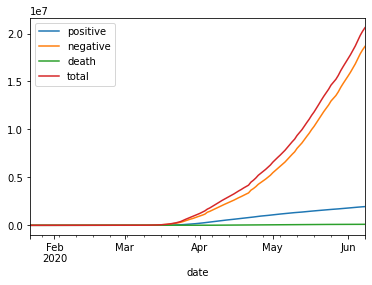

In [14]:
x=gbUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

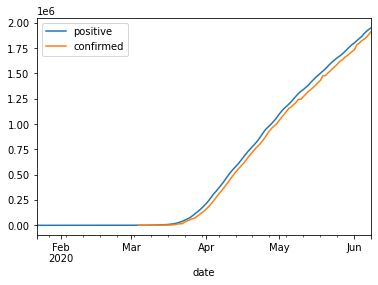

In [15]:
dfResults = gbUSA.sum().join(dfWHO, how='left', rsuffix='_who' )
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

# John Hopkins Data


In [16]:
dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()

confirmed    1960897
dead          110990
dtype: int64

In [17]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

confirmed    133816
dead           4657
dtype: int64

In [0]:
dfJHUUS = dfJHUData[dfJHUData.country=='US']
gbJHUByState= dfJHUUS.groupby(by='state')
gbJHUByCountry = dfJHUData.groupby(by='country')

In [19]:
dfJHUData.head()

,FIPS,city,state,country,last_update,lat,lon,confirmed,dead,recovered,active,key
0,45001.0,Abbeville,South Carolina,US,2020-06-09 03:33:03,34.223334,-82.461707,58,0,0,58,"Abbeville, South Carolina, US"
1,22001.0,Acadia,Louisiana,US,2020-06-09 03:33:03,30.295065,-92.414197,513,29,0,484,"Acadia, Louisiana, US"
2,51001.0,Accomack,Virginia,US,2020-06-09 03:33:03,37.767072,-75.632346,983,13,0,970,"Accomack, Virginia, US"
3,16001.0,Ada,Idaho,US,2020-06-09 03:33:03,43.452658,-116.241552,844,22,0,822,"Ada, Idaho, US"
4,19001.0,Adair,Iowa,US,2020-06-09 03:33:03,41.330756,-94.471059,9,0,0,9,"Adair, Iowa, US"


In [20]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(10)

country
US                1960897
Brazil             707412
Russia             476043
United Kingdom     288834
India              265928
Spain              241717
Italy              235278
Peru               199696
France             191313
Germany            186109
Name: confirmed, dtype: int64

In [21]:
dfctd_state_curr.head()

,total_positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,fips,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AK,563,65349,0,7.0,0.0,0.0,0.0,0.0,0.0,384.0,B,6/8/2020 00:00,2020-06-08T00:00:00Z,06/07 20:00,10,0.0,2020-06-08T00:00:00Z,02,19,989,65912,65912,1008,65912,0,0,06594e7f361ff9a5128a34de7a6f674b27c067ed,0,0,0,0,0,
AL,20925,239066,0,0.0,2054.0,0.0,623.0,0.0,371.0,11395.0,B,6/8/2020 11:00,2020-06-08T11:00:00Z,06/08 07:00,718,2054.0,2020-06-08T11:00:00Z,01,425,0,259991,259991,425,259991,26,32,b8596160c71e9a7a19933497105b33a6f96ab6f4,0,0,0,0,0,
AR,9740,150847,0,171.0,844.0,0.0,0.0,46.0,143.0,6424.0,A,6/8/2020 15:10,2020-06-08T15:10:00Z,06/08 11:10,155,844.0,2020-06-08T15:10:00Z,05,314,0,160587,160587,314,160587,1,0,4601d4a70338d69cb5face8b1cc874f7d6f2f555,0,0,0,0,0,
AS,0,174,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C,6/1/2020 00:00,2020-06-01T00:00:00Z,05/31 20:00,0,0.0,2020-06-01T00:00:00Z,60,0,0,174,174,0,174,0,0,56b5b15cf44231c18d5e9ad39b896273ae1124e0,0,0,0,0,0,
AZ,27678,260403,0,1266.0,3377.0,390.0,0.0,246.0,0.0,5639.0,A+,6/8/2020 00:00,2020-06-08T00:00:00Z,06/07 20:00,1047,3377.0,2020-06-08T00:00:00Z,04,789,5671,288081,288081,6460,288081,3,25,28c5ebf84c4b542c7baa079620da4ee18e34e973,0,0,0,0,0,


In [0]:
dfState = dfCovidtracking.reset_index()[['date','state','positive', 'death']].set_index('state') \
  .join(dfctd_state_curr.total_positive)

In [0]:
dfState['pct']=dfState.positive/dfState.total_positive

In [24]:
dfState.loc['FL'].head(14)


,date,positive,death,total_positive,pct
state,,,,,
FL,2020-06-08,64904,2798,64904,1.000000
FL,2020-06-07,63938,2786,64904,0.985116
FL,2020-06-06,62758,2773,64904,0.966936
FL,2020-06-05,61488,2745,64904,0.947368
FL,2020-06-04,60183,2691,64904,0.927262
FL,2020-06-03,58764,2650,64904,0.905399
FL,2020-06-02,57447,2613,64904,0.885107
FL,2020-06-01,56830,2543,64904,0.875601
FL,2020-05-31,56163,2534,64904,0.865324


In [0]:
res = dfState.reset_index().pivot(index = 'date', columns='state', values='pct').fillna(0)

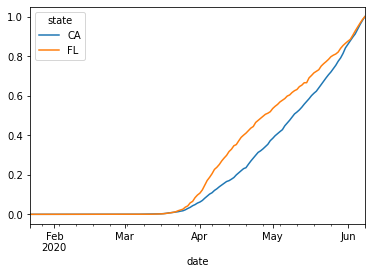

In [26]:
x = res.loc[:, ['CA','FL']].plot.line()

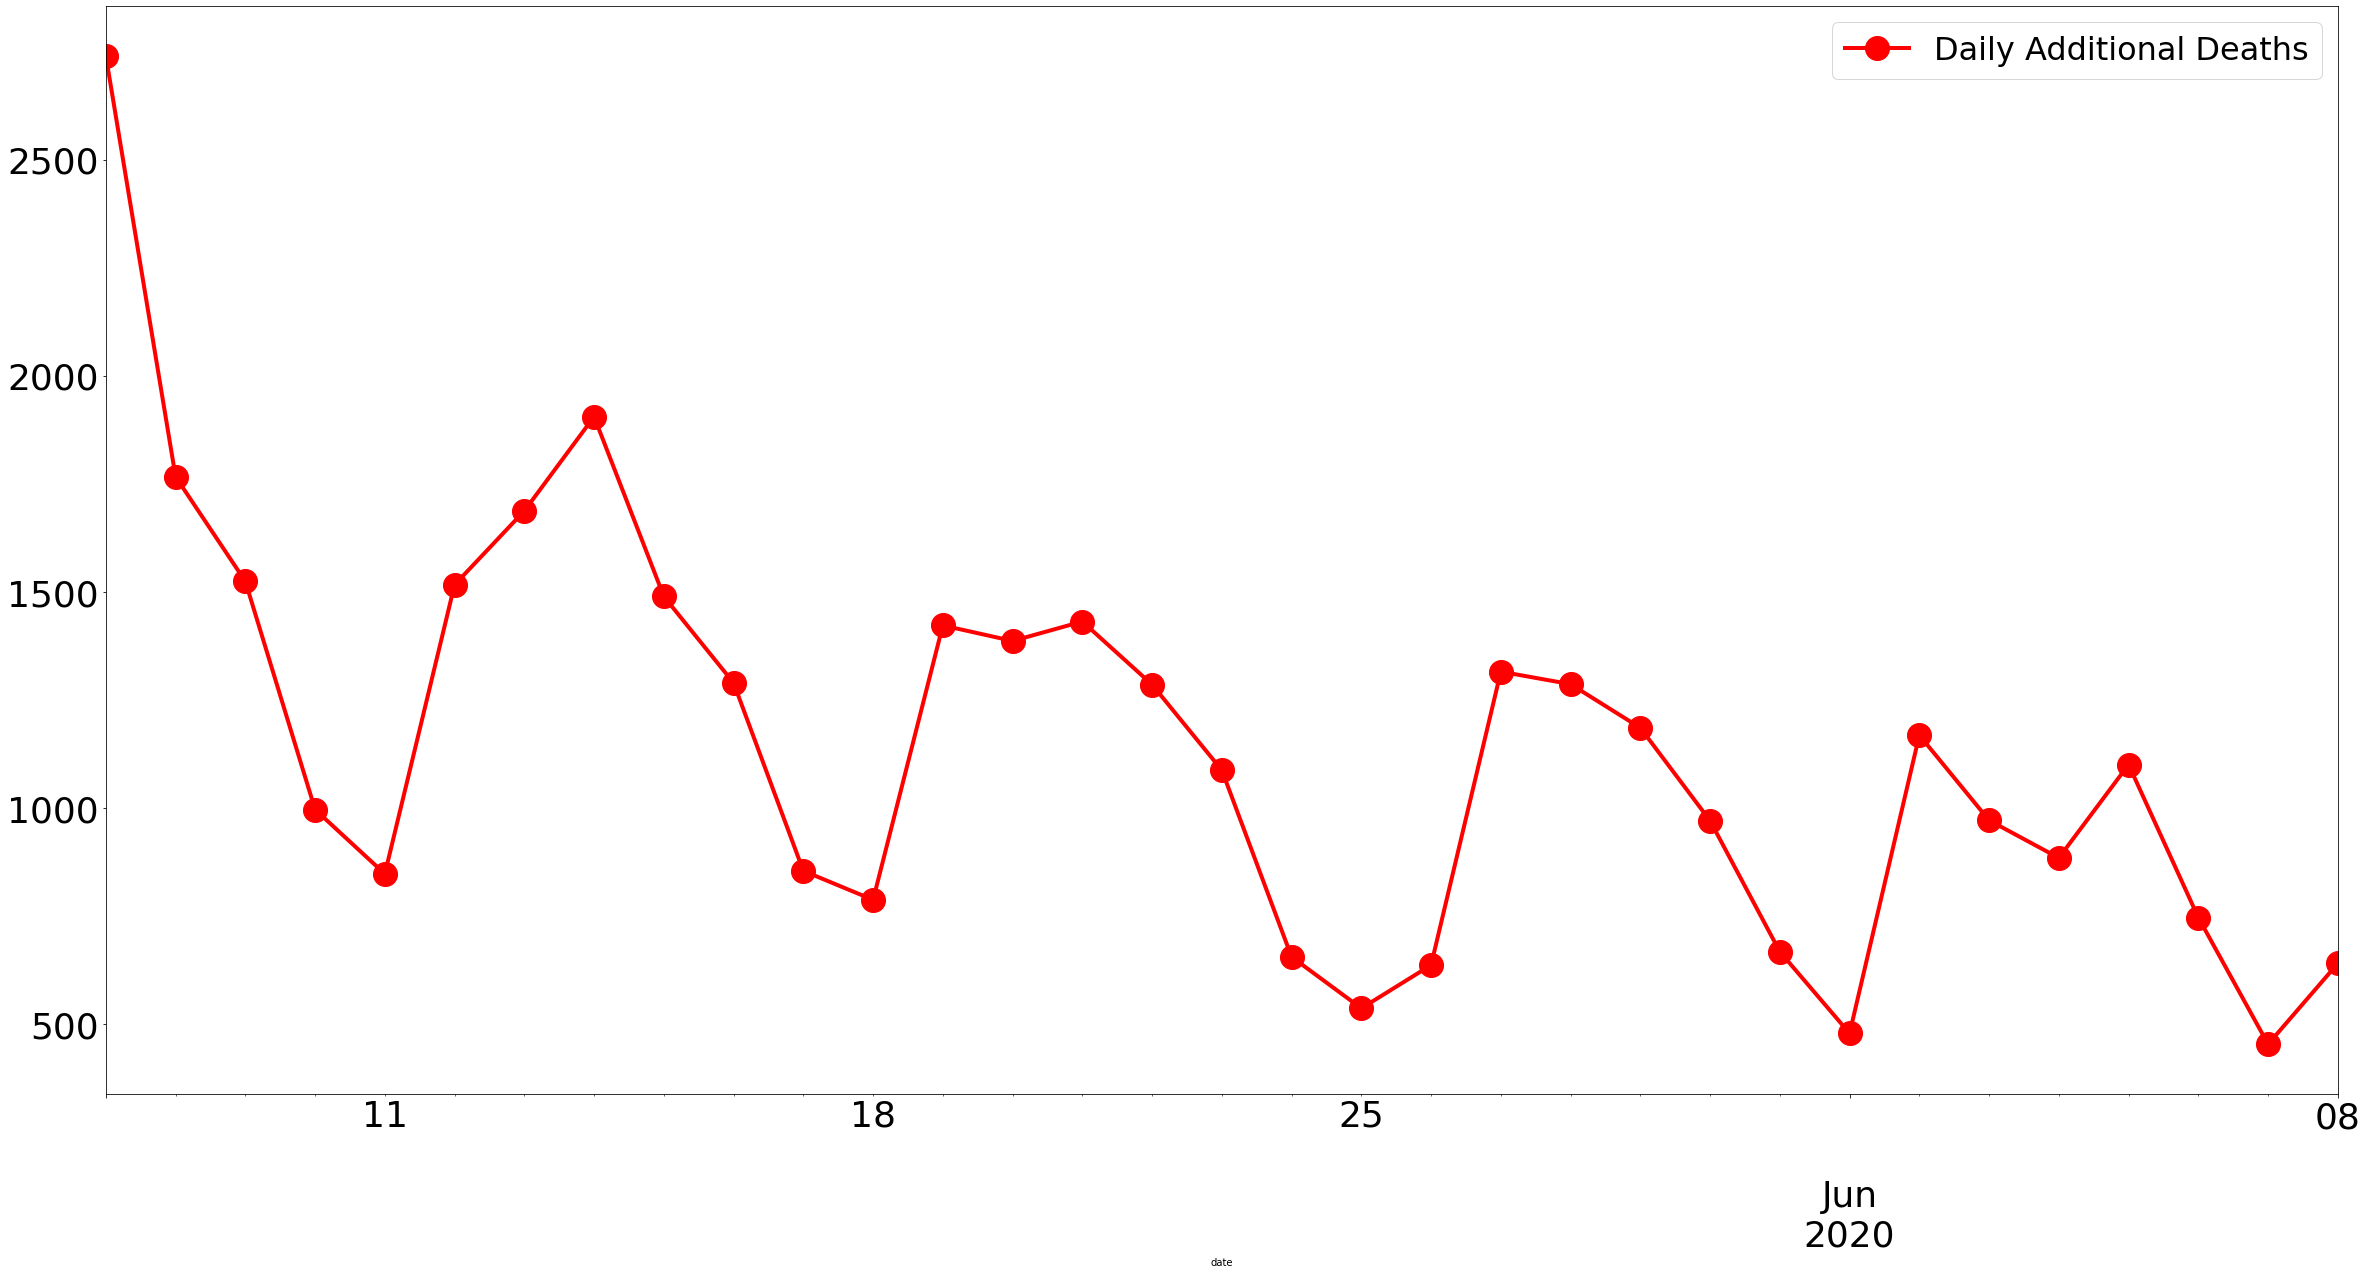

In [27]:
x = dfCovidtracking.groupby(by='date')
y1=x.sum()[-33:].deathIncrease.plot.line(figsize=(40,20), fontsize=36, \
  style='.-', markersize=48, color='red', linewidth=4) \
.legend(['Daily Additional Deaths'],fontsize=32)


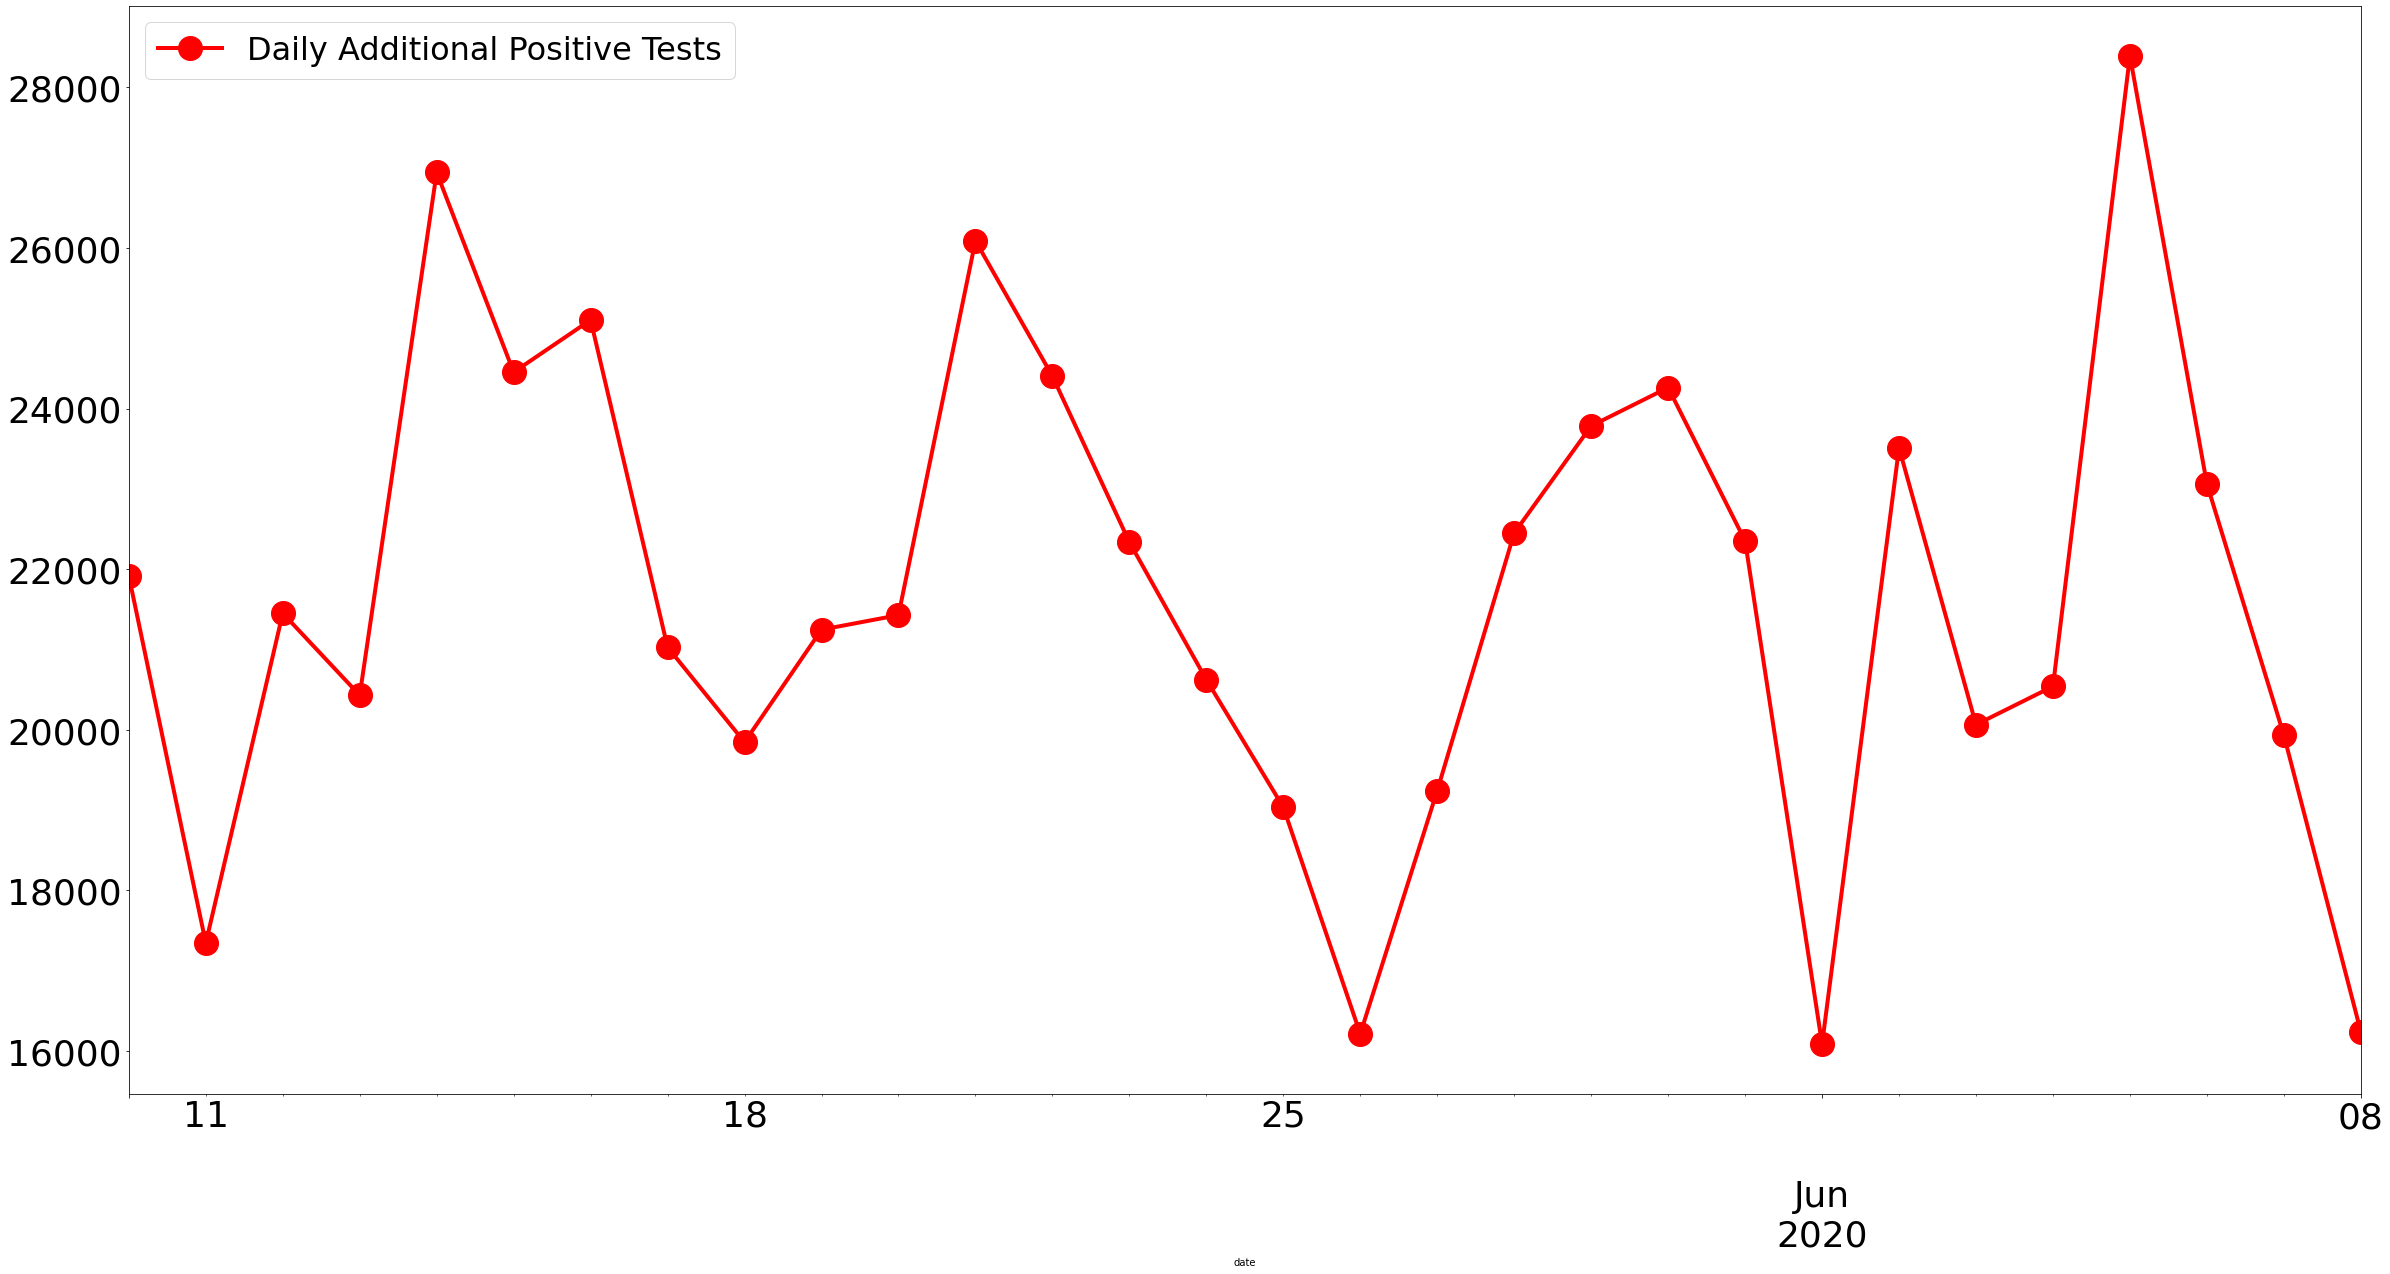

In [28]:
x = dfCovidtracking.groupby(by='date')
y1=x.sum()

chart = y1[-30:].positiveIncrease.plot.line(figsize=(40,20), fontsize=36, \
  style='.-', markersize=48, color='red', linewidth=4) \
.legend(['Daily Additional Positive Tests'],fontsize=32)


In [0]:
def getWeek(dt):
  return (dt.year*100)+dt.week

dfByWeekYear = dfCovidtracking[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']].groupby(by=getWeek)


In [0]:
def getWeek(dt):
  return (dt.year*100)+dt.week

dfDoW = dfCovidtracking[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']].groupby(by=lambda x: x.dayofweek)


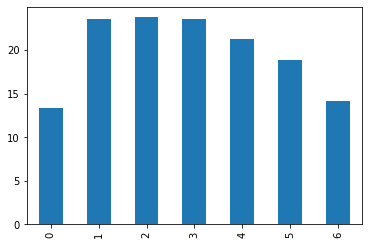

In [31]:
dfDoW.mean().deathIncrease.plot.bar()



In [32]:
dfByWeekYear.sum()[-7:]

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
202018,12704,24581,1464857,191823,1656680
202019,12406,18998,1739843,170932,1910775
202020,9587,12129,2326573,156743,2483316
202021,8053,15648,2565379,155969,2721348
202022,6595,26480,2622855,147333,2770188
202023,5800,6823,3124121,151583,3275704
202024,640,675,363385,16240,379625


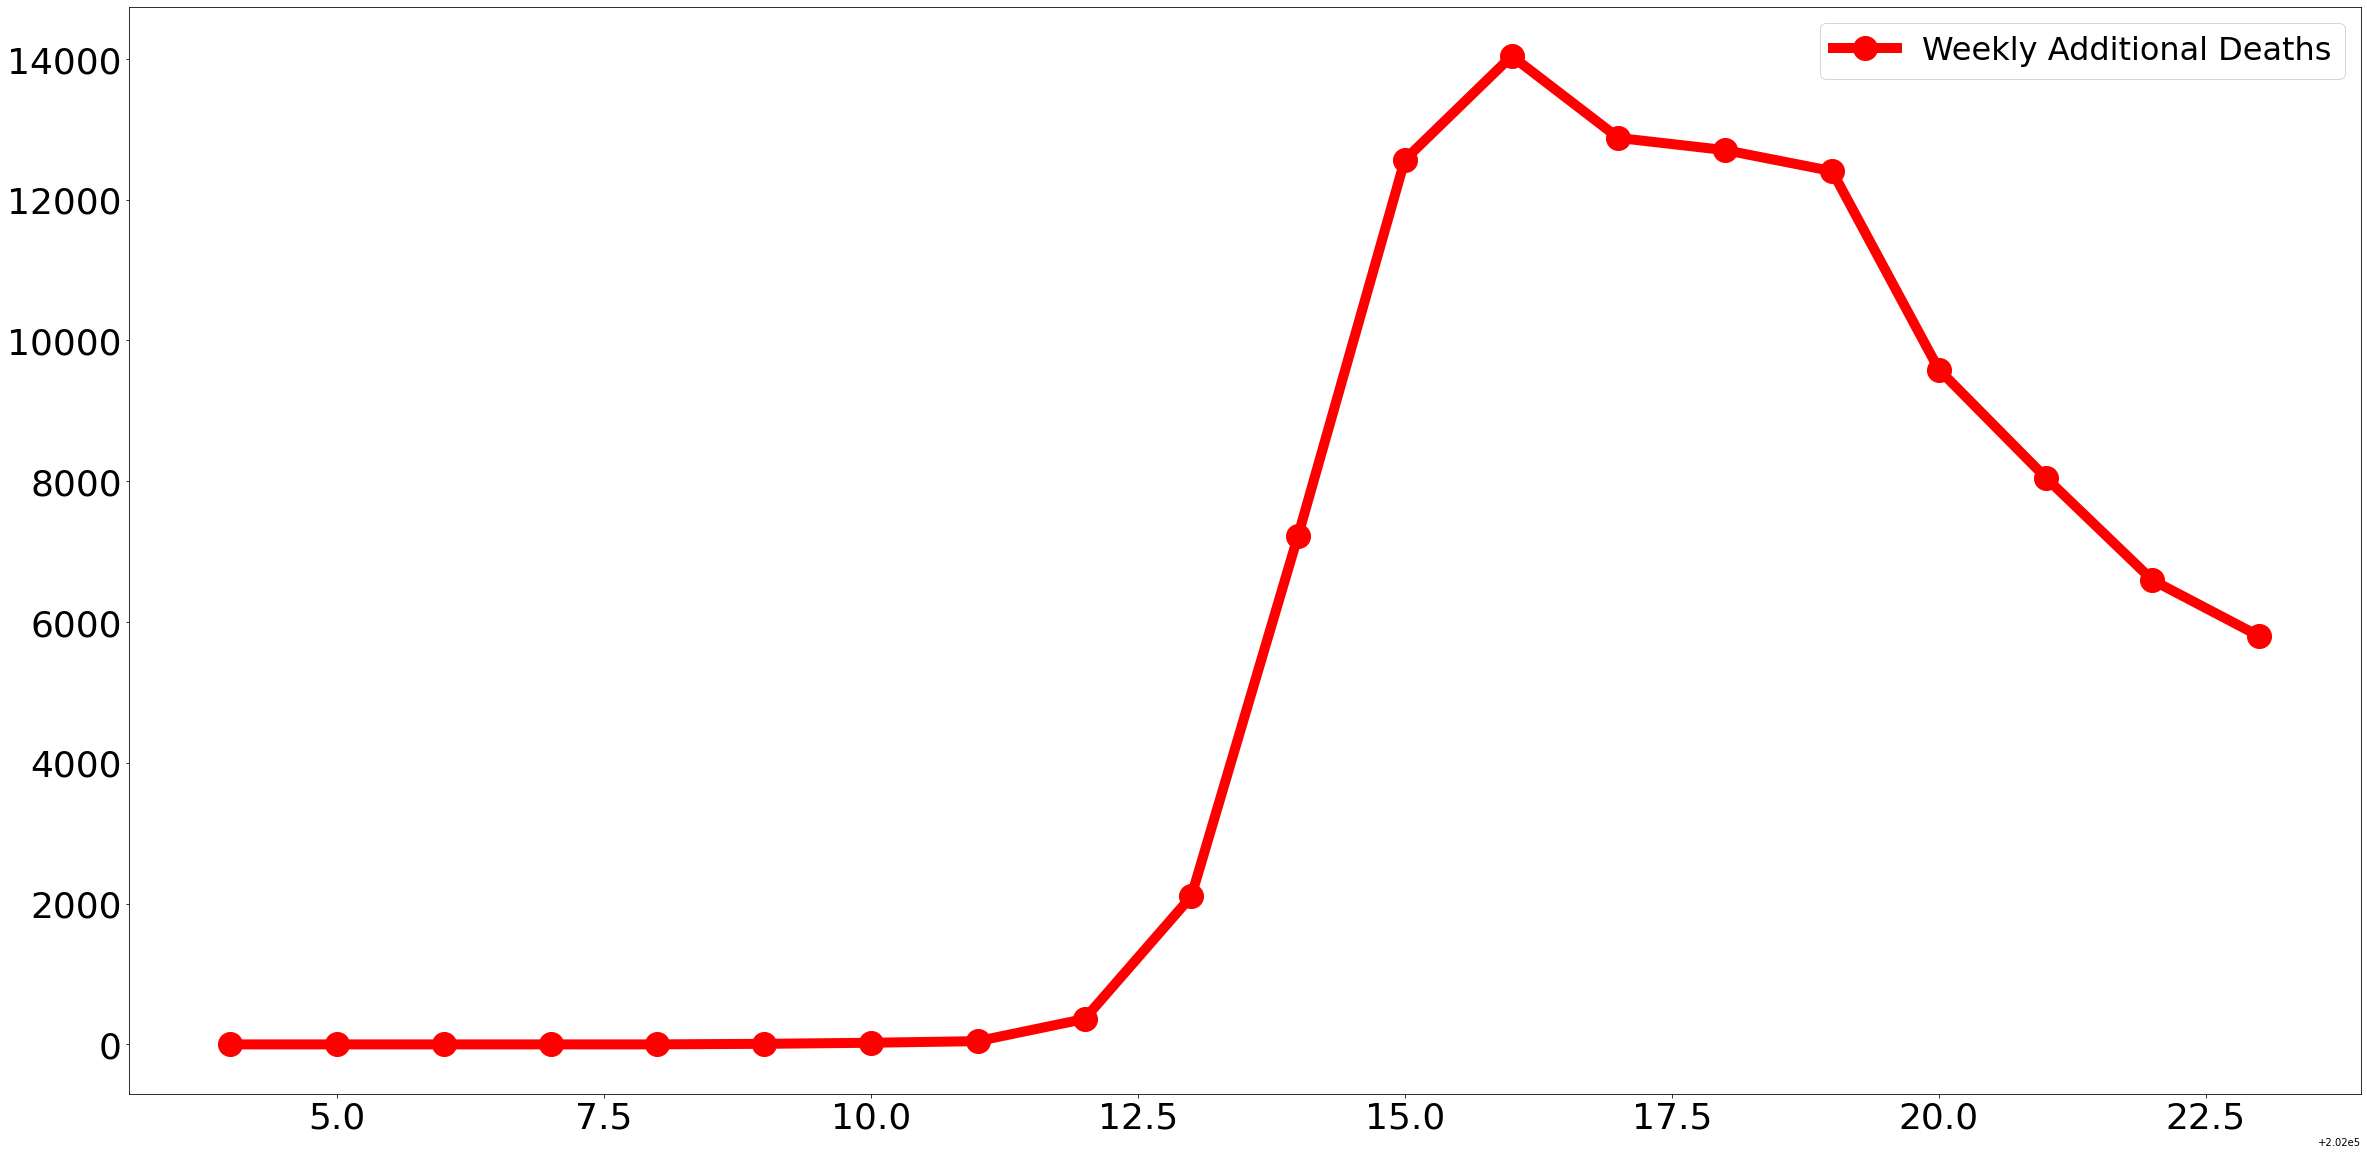

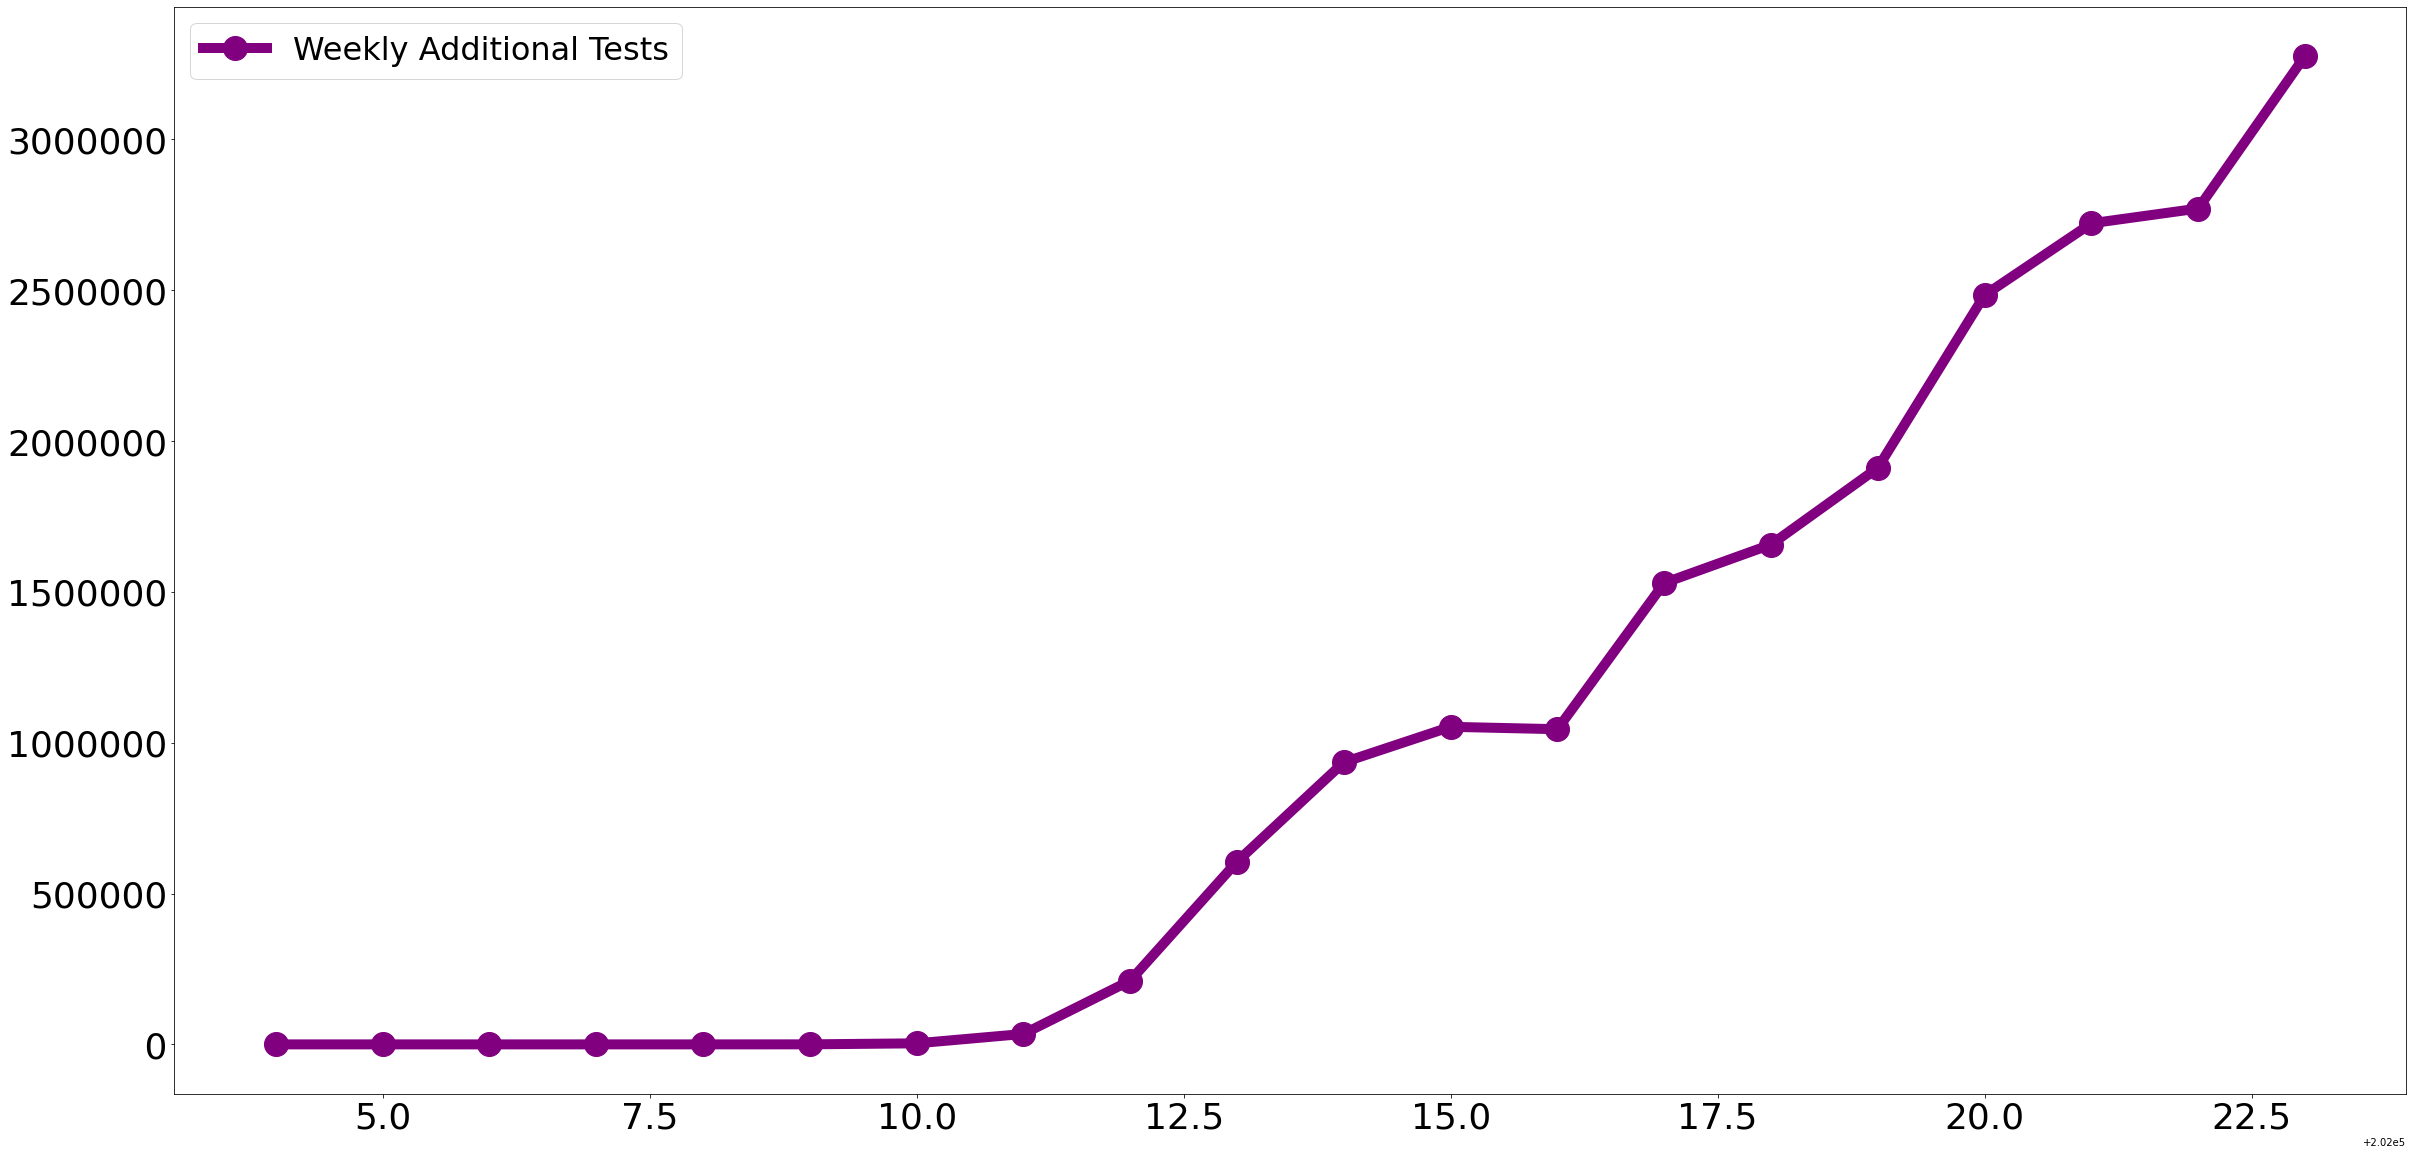

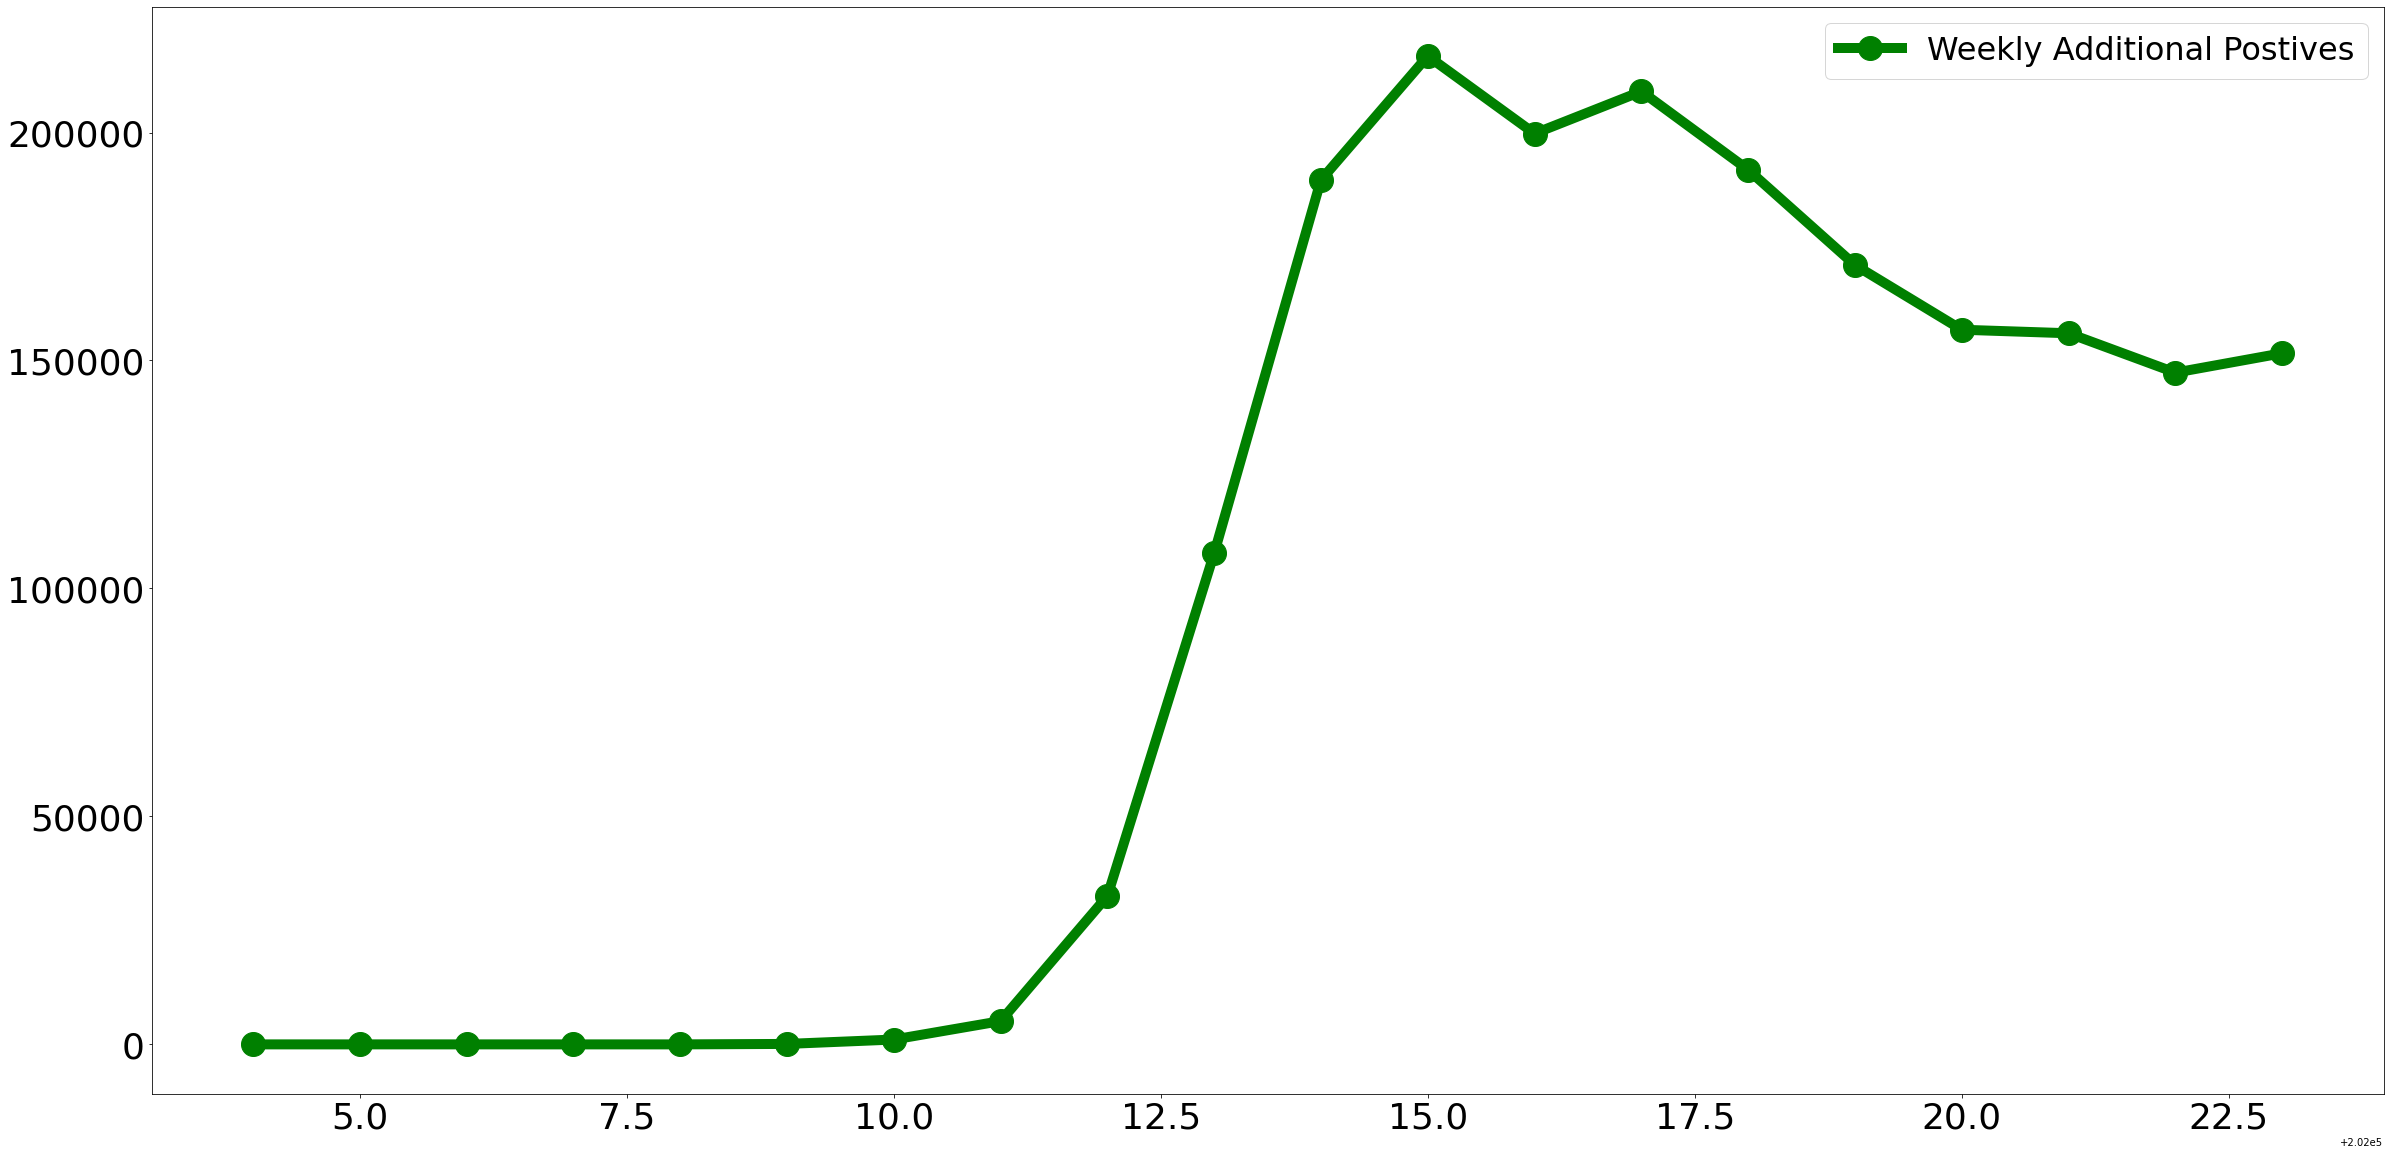

In [33]:
import matplotlib.ticker as ticker
plt1 = dfByWeekYear.sum()[:-1][['deathIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='red')
plt1.legend(['Weekly Additional Deaths'],fontsize=32)
plt2 = dfByWeekYear.sum()[:-1][['totalTestResultsIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='purple')
plt2.legend(['Weekly Additional Tests'],fontsize=32)

plt2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%6.0d'))
    
plt3 = dfByWeekYear.sum()[:-1][['positiveIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='green')
plt3.legend(['Weekly Additional Postives'],fontsize=32)

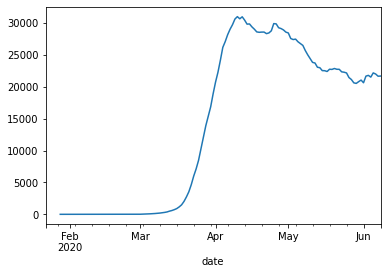

In [34]:
dfCovidtracking.groupby(by='date').sum().rolling(window=7).mean().positiveIncrease.plot.line()

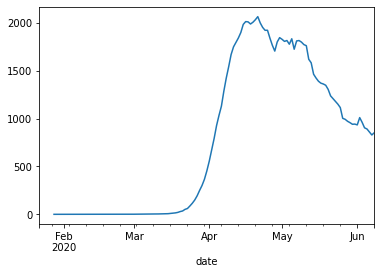

In [35]:
dfCovidtracking.groupby(by='date').sum().rolling(window=7).mean().deathIncrease.plot.line()

In [0]:
dfCAAvg = dfCovidtracking[dfCovidtracking.state=='CA'] \
.groupby(by='date').sum().rolling(window=7).mean()

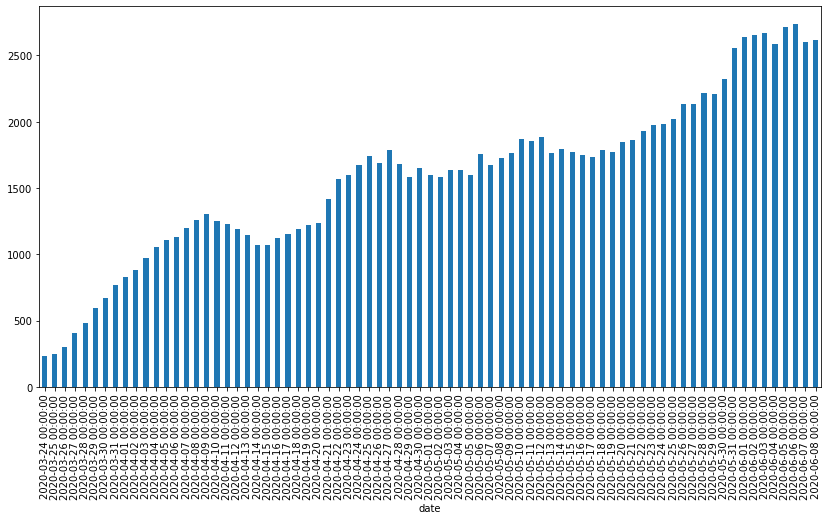

In [37]:

graph1 = dfCAAvg[20:].positiveIncrease.plot.bar(figsize=(14,7))


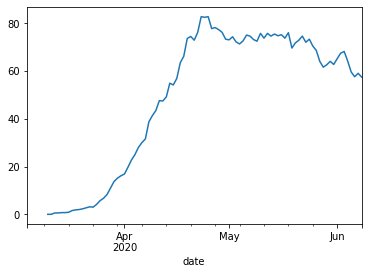

In [38]:
dfCAAvg.deathIncrease.plot.line()

In [39]:
dfDates = dfState.reset_index().copy()
dfDates[(dfDates.state.isin(['TN']))].head(10)

,state,date,positive,death,total_positive,pct
4349,TN,2020-06-08,26944,421,26944,1.000000
4350,TN,2020-06-07,26381,418,26944,0.979105
4351,TN,2020-06-06,26071,417,26944,0.967599
4352,TN,2020-06-05,25520,408,26944,0.947150
4353,TN,2020-06-04,25120,401,26944,0.932304
4354,TN,2020-06-03,24822,388,26944,0.921244
4355,TN,2020-06-02,24375,381,26944,0.904654
4356,TN,2020-06-01,23554,367,26944,0.874183
4357,TN,2020-05-31,23006,364,26944,0.853845
4358,TN,2020-05-30,22566,364,26944,0.837515


In [40]:
datecutoff = dfDates.date.max()-datetime.timedelta(days=7)
dfDates[(dfDates.date == datecutoff) & (dfDates.pct < .85)].sort_values(by='pct')


,state,date,positive,death,total_positive,pct
376,AZ,2020-06-01,20123,917,27678,0.727040
196,AR,2020-06-01,7443,133,9740,0.764168
3980,PR,2020-06-01,3873,136,5046,0.767539
2557,MP,2020-06-01,22,2,28,0.785714
2830,NC,2020-06-01,29263,898,36484,0.802078
4549,UT,2020-06-01,9999,113,12322,0.811475
4165,SC,2020-06-01,12148,500,14800,0.820811
7,AK,2020-06-01,467,10,563,0.829485


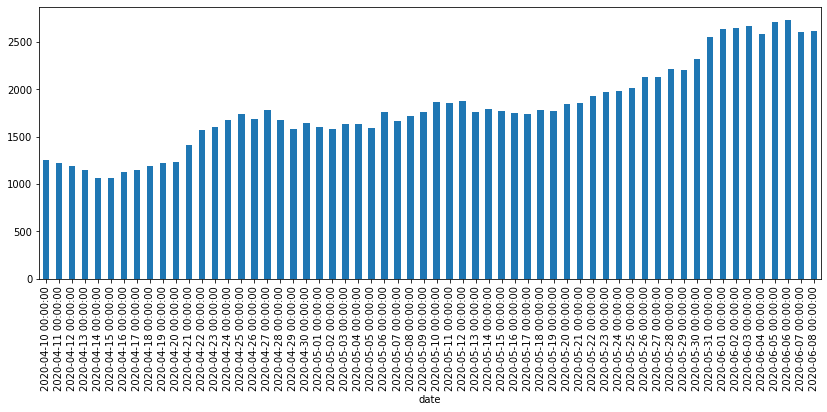

In [41]:

def showStateData(state):
  return dfCovidtracking[dfCovidtracking.state==state]\
  .sort_index()\
  .copy()



chart = showStateData('CA')\
.positiveIncrease\
.rolling(window=7)\
.mean()[-60:].plot.bar(figsize=(14,5))

In [42]:
dfTest = dfCovidtracking[dfCovidtracking.state=='CA'].sort_index().copy()
dfTest.head()

,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,fips,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-04,CA,53,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,06,0,0,515,515,0,515,0,0,ae2b9d2e5d691c66d1abe7c43c3564e865279fd9,0,0,0,0,0,
2020-03-05,CA,53,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,06,0,0,515,515,0,515,0,0,10c1ce97af2a37d316e43bb512b486d8c380ca37,0,0,0,0,0,
2020-03-06,CA,60,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,06,7,0,522,522,7,522,0,0,2790f2f9e9ab3cc94caca4b0a2c7d0ecb23ddcf6,0,0,0,0,0,
2020-03-07,CA,69,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,06,9,0,531,531,9,531,0,0,af5f339fc3168c1f9135ea735ef21475b35a8c01,0,0,0,0,0,
2020-03-08,CA,88,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,06,19,0,550,550,19,550,0,0,bcf5160531e8ce70a9a61aa770e6aa4e869161ef,0,0,0,0,0,


In [43]:
dfTest.head()

,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,fips,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-04,CA,53,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,06,0,0,515,515,0,515,0,0,ae2b9d2e5d691c66d1abe7c43c3564e865279fd9,0,0,0,0,0,
2020-03-05,CA,53,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,06,0,0,515,515,0,515,0,0,10c1ce97af2a37d316e43bb512b486d8c380ca37,0,0,0,0,0,
2020-03-06,CA,60,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,06,7,0,522,522,7,522,0,0,2790f2f9e9ab3cc94caca4b0a2c7d0ecb23ddcf6,0,0,0,0,0,
2020-03-07,CA,69,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,06,9,0,531,531,9,531,0,0,af5f339fc3168c1f9135ea735ef21475b35a8c01,0,0,0,0,0,
2020-03-08,CA,88,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,06,19,0,550,550,19,550,0,0,bcf5160531e8ce70a9a61aa770e6aa4e869161ef,0,0,0,0,0,


# State Population Data


In [0]:
data_url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv"


In [0]:
dfUSPop = pd.read_csv(data_url)

In [46]:
import math
us_pop = dfUSPop.loc[0].POPESTIMATE2019 #Estimate from Wikipedia
res = dfCovidtracking.loc[dfCovidtracking.index.max()][['positive', 'negative', 'pending','death', 'total']].sum()
cir = res.positive/res.total
cfr = res.death/res.positive
p_aff= math.ceil(us_pop*cir)
p_dead= math.ceil(p_aff*cfr)
print(res)
print(f"Current Infection Rate {cir*100:2f}%")
print(f"Percentage of US affected: {(res.positive+res.death)/us_pop*100:2f}%")
print(f"Observed CFR: {cfr*100:2f}%")
print(f"Percentage of US tested/affected: {(res.negative+res.positive+res.death)/us_pop*100:2f}%")
print(f"Projected affected by cir = {p_aff:,d}")
print(f"Projected killed = {p_dead:,d}")


positive     1952401
negative    18662902
pending         1606
death         105040
total       20616909
dtype: int64
Current Infection Rate 9.469902%
Percentage of US affected: 0.626811%
Observed CFR: 5.380042%
Percentage of US tested/affected: 6.312568%
Projected affected by cir = 31,083,960
Projected killed = 1,672,331


In [0]:
!if [ ! -d "loc" ]; then \
git clone https://gist.github.com/rogerallen/1583593 --depth=1 --quiet loc; \
fi
import sys
sys.path.append("loc")




In [0]:
import us_state_abbrev as us_abbr


In [0]:
dfStatePop = dfUSPop[dfUSPop.STATE != 0].copy()

In [0]:
dfStatePop['ABBR']=dfStatePop.NAME.apply(lambda x: us_abbr.us_state_abbrev[x])

In [0]:
dfStatePop = dfStatePop.loc[:, ['ABBR', 'POPESTIMATE2019']]
dfStatePop.set_index('ABBR', inplace=True)

In [0]:
dfStateCovid = dfCovidtracking.loc[dfCovidtracking.index.max()].set_index('state')

In [0]:
dfStateJoin = dfStateCovid.join(dfStatePop)

In [54]:
pd.DataFrame([(dfStateJoin.positive / dfStateJoin.POPESTIMATE2019)*100, \
              (dfStateJoin.totalTestResults/ dfStateJoin.POPESTIMATE2019)*100],\
             index=['state_pos_pop','state_test_pop'] ).\
             T.sort_values(by="state_pos_pop", ascending=False)[:50]

,state_pos_pop,state_test_pop
state,,
NY,1.947196,13.138448
NJ,1.851987,10.978025
MA,1.503460,9.535999
RI,1.476550,16.912931
DC,1.330360,7.901676
CT,1.236703,8.640847
DE,1.024067,7.183157
IL,1.019104,8.361837
MD,0.966045,6.144933


In [55]:
#print(f"Current Infection Rate {res.positive/res.total*100:2f}%")

print(f"Current Testing Percent {gbUSA.sum().tail(1).totalTestResults[0]/dfUSPop[dfUSPop.REGION=='0'].POPESTIMATE2019[0]*100:2f}%")

Current Testing Percent 6.280567%


In [56]:
dfJHUData.columns

Index(['FIPS', 'city', 'state', 'country', 'last_update', 'lat', 'lon',
       'confirmed', 'dead', 'recovered', 'active', 'key'],
      dtype='object')

# OWID Data

In [0]:
dfOwid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

In [58]:
dfOwid.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22662 entries, 0 to 22661
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   iso_code                         22598 non-null  object 
 1   continent                        22437 non-null  object 
 2   location                         22662 non-null  object 
 3   date                             22662 non-null  object 
 4   total_cases                      22662 non-null  int64  
 5   new_cases                        22662 non-null  int64  
 6   total_deaths                     22662 non-null  int64  
 7   new_deaths                       22662 non-null  int64  
 8   total_cases_per_million          22271 non-null  float64
 9   new_cases_per_million            22271 non-null  float64
 10  total_deaths_per_million         22271 non-null  float64
 11  new_deaths_per_million           22271 non-null  float64
 12  total_tests       

In [0]:
dfOwidTests = dfOwid.dropna(subset=['total_tests']).copy()

In [0]:
dfOwidLatest = dfOwidTests.sort_values(by='date').groupby('iso_code').last()

In [61]:
dfOwidLatest.total_tests.sort_values(ascending=False)

iso_code
USA    20384850.0
RUS    12721549.0
IND     4666386.0
DEU     4348880.0
ITA     4187057.0
          ...    
PRY       35258.0
BOL       33946.0
MDV       26243.0
CRI       21275.0
ZWE       21000.0
Name: total_tests, Length: 84, dtype: float64

In [62]:
isUSA = dfOwidLatest.index.isin(['USA'])
NonUSTests = dfOwidLatest[~isUSA].total_tests.sum()
USTests = dfOwidLatest[isUSA].total_tests.sum()

print(f"Total testing done outside of USA: {NonUSTests:.0f}")
print(f"Total tests done in USA : {USTests:.0f}")
print(f"How many more times has the world tested more than the US: {NonUSTests/USTests:.1f}")

Total testing done outside of USA: 60732849
Total tests done in USA : 20384850
How many more times has the world tested more than the US: 3.0


In [63]:
dfOwidLatest[isUSA].sum()

continent                            North America
location                             United States
date                                    2020-06-05
total_cases                                1872660
new_cases                                    21140
total_deaths                                108211
new_deaths                                    1036
total_cases_per_million                    5657.54
new_cases_per_million                       63.867
total_deaths_per_million                   326.919
new_deaths_per_million                        3.13
total_tests                            2.03848e+07
new_tests                                   573607
total_tests_per_thousand                    61.585
new_tests_per_thousand                       1.733
new_tests_smoothed                          512953
new_tests_smoothed_per_thousand               1.55
tests_units                        tests performed
stringency_index                             72.69
population                     

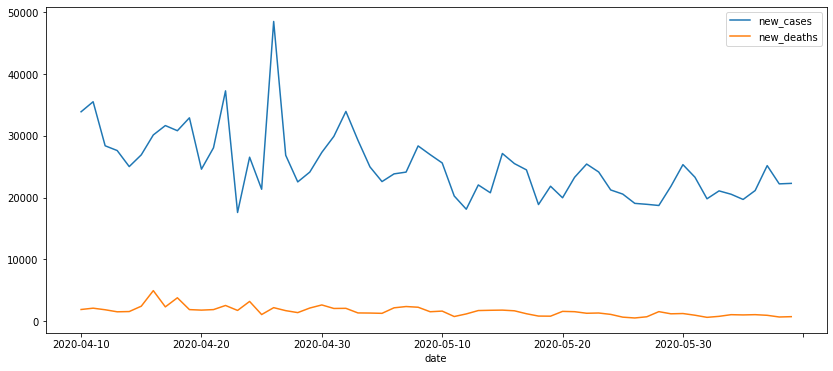

In [64]:
dfOwidUSA = dfOwid.loc[dfOwid.iso_code=='USA']

dfOwidUSA.set_index('date')[['new_cases','new_deaths']][-60:].plot.line(figsize=(14,6))

In [0]:
state = 'GA'
dfRollingWeekState = dfCovidtracking.loc[dfCovidtracking.state==state]\
.rolling(window=7).mean()


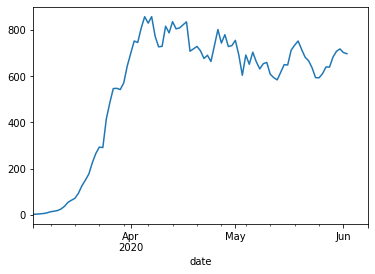

In [66]:
plt = dfRollingWeekState.positiveIncrease.plot.line()

In [67]:
dfJHUData[dfJHUData.state=='Florida'].confirmed.sum()

64904

In [0]:
doWGA = dfCovidtracking[dfCovidtracking.state=='GA'][['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']]\
.groupby(lambda x: x.dayofweek)

In [69]:
doWGA.sum()

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,346,1137,85445,6414,91859
1,466,1723,66032,8118,74150
2,371,1851,-11209,8635,-2574
3,349,1268,63977,7418,71395
4,336,1313,91942,8972,100914
5,203,1111,95506,6654,102160
6,137,343,105185,6284,111469


# Socrata (San Francisco) Data

In [70]:
!pip install sodapy

In [0]:
from sodapy import Socrata

In [0]:
client = Socrata("data.sfgov.org", "LCSuN5PrqWkGtBe9dULkS75Rz")
results_df = pd.DataFrame.from_records(client.get("tvq9-ec9w"))

In [73]:
results_df.case_disposition.unique()

array(['Confirmed', 'Death'], dtype=object)

In [0]:
res = results_df.astype({'case_count':'int16'})

In [0]:
dfresConf = res[res.case_disposition=='Confirmed']
dfresDead = res[res.case_disposition=='Death']

In [0]:
dfTotals = dfresConf.groupby(by='date').sum().join(dfresDead.groupby(by='date').sum(), \
        rsuffix='dead').fillna(0) \
        .rename(columns={'case_count':'positive', 'case_countdead':'dead'})

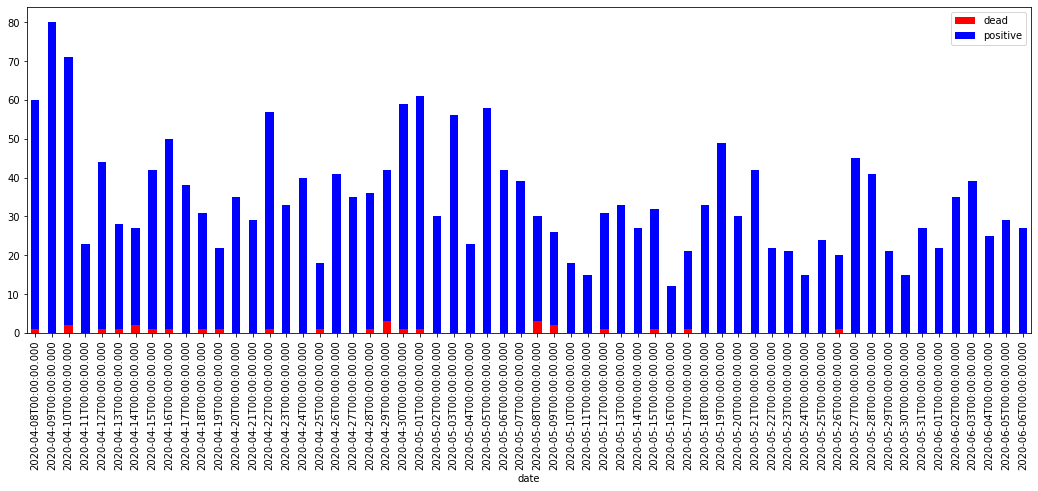

In [77]:
chart = dfTotals[['dead', 'positive']][-60:]\
.plot.bar(figsize=(18,6),stacked=True, color=['red','blue'])

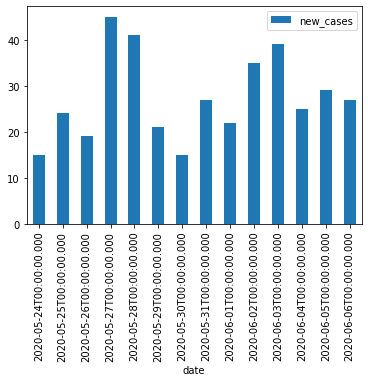

In [78]:
dfresConf.groupby('date').sum().rename(columns={'case_count':'new_cases'}).tail(14).plot.bar()

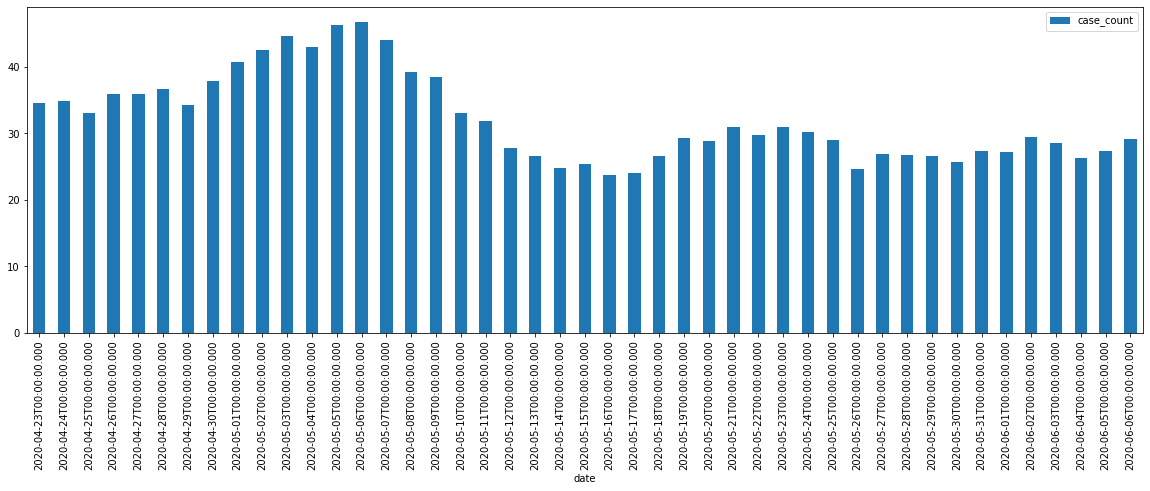

In [79]:
dfresConf.groupby('date').sum().rolling(window=7).mean()[-45:].plot.bar(figsize=(20,6))

# Marin Data

In [0]:
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSRmO2pStf7Ft1yYjDULluZXzUAczGK_B34hDemDBadGEY0HTLwlcadF2cHNEwmmvLetUTf-D2ruYCT/pub?gid=0&single=true&output=csv"

df = pd.read_csv(url, header=1, parse_dates=[0], usecols=[0,1,3,5,6,7], index_col=[0])

In [81]:
df.tail()

,positive,deaths,tested,hospitalizations,Recovered
date,,,,,
2020-06-03,525,17.0,14430.0,52.0,366.0
2020-06-04,530,17.0,14592.0,52.0,392.0
2020-06-05,551,17.0,15034.0,52.0,401.0
2020-06-06,571,17.0,15573.0,52.0,405.0
2020-06-07,589,17.0,15962.0,52.0,405.0


In [82]:
df[['deaths','positive']].diff()

,deaths,positive
date,,
2020-03-06,NaN,NaN
2020-03-07,0.0,0.0
2020-03-08,0.0,1.0
2020-03-09,0.0,0.0
2020-03-10,NaN,0.0
...,...,...
2020-06-03,0.0,19.0
2020-06-04,0.0,5.0
2020-06-05,0.0,21.0


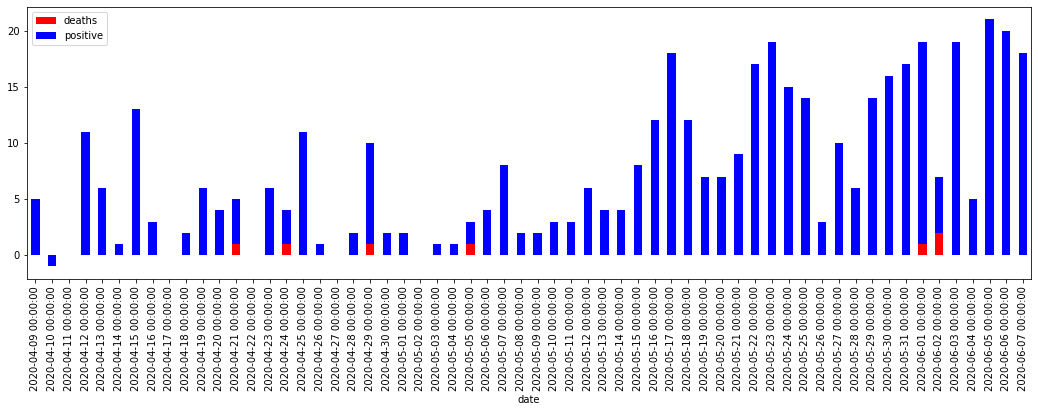

In [83]:
chart= df[['deaths','positive']].diff()[-60:]\
.plot.bar(stacked=True,figsize=(18,5), color=['r','b'])

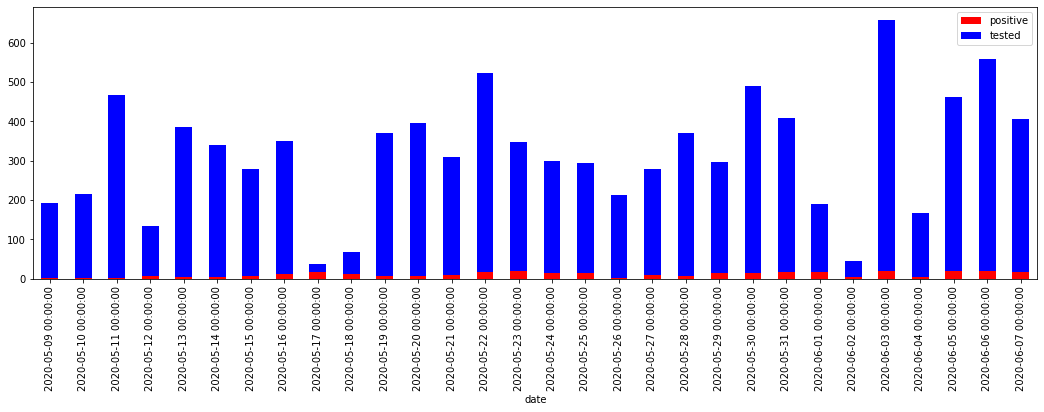

In [84]:
chart= df[['positive','tested']].diff()[-30:]\
.plot.bar(stacked=True,figsize=(18,5), color=['r','b'])

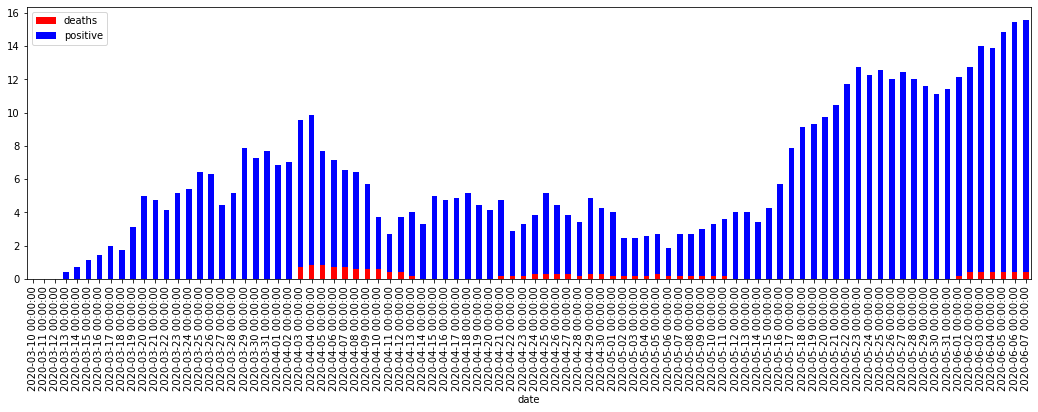

In [85]:
chart= df[['deaths','positive']].diff()\
.rolling(window=7).mean()[-90:]\
.plot.bar(stacked=True,figsize=(18,5), color=['r','b'])

In [86]:
marin_pop = 259725

print(f"Marin Population Positive: {(df[-1:].positive.values[0]/marin_pop)*100:2.2f}%")
print(f"Marin Population Tested: {(df[-1:].tested.values[0]/marin_pop)*100:2.2f}%")

Marin Population Positive: 0.23%
Marin Population Tested: 6.15%


In [87]:
df.positive.diff().rolling(window=7).mean().tail()

date
2020-06-03    13.571429
2020-06-04    13.428571
2020-06-05    14.428571
2020-06-06    15.000000
2020-06-07    15.142857
Name: positive, dtype: float64

In [88]:
dfCovidtracking[dfCovidtracking.state=='CA'].head(28)[::-1].positive.diff()


date
2020-05-12       NaN
2020-05-13    1759.0
2020-05-14    2023.0
2020-05-15    1772.0
2020-05-16    1857.0
2020-05-17    2046.0
2020-05-18    1591.0
2020-05-19    1365.0
2020-05-20    2262.0
2020-05-21    2140.0
2020-05-22    2247.0
2020-05-23    2187.0
2020-05-24    2079.0
2020-05-25    1848.0
2020-05-26    2175.0
2020-05-27    2247.0
2020-05-28    2717.0
2020-05-29    2189.0
2020-05-30    2992.0
2020-05-31    3705.0
2020-06-01    2423.0
2020-06-02    2304.0
2020-06-03    2377.0
2020-06-04    2120.0
2020-06-05    3094.0
2020-06-06    3115.0
2020-06-07    2796.0
2020-06-08    2507.0
Name: positive, dtype: float64